# E/I balance network for fast response

Implementation of the paper：
- Tian, Gengshuo, et al. "Excitation-Inhibition Balanced
  Neural Networks for Fast Signal Detection." Frontiers in
  Computational Neuroscience 14 (2020): 79.

In [1]:
import brainpy as bp
import brainpy.numpy as np

In [2]:
# set parameters
bp.profile.set(backend='numba', numerical_method='exponential')

num = 10000
num_inh = int(num * 0.2)
num_exc = num - num_inh
prob = 0.25

tau_E = 15.
tau_I = 10.
V_reset = 0.
V_threshold = 15.
f_E = 3.
f_I = 2.
mu_f = 0.1

tau_Es = 6.
tau_Is = 5.
JEE = 0.25
JEI = -1.
JIE = 0.4
JII = -1.

In [3]:
# define neuron type
def get_neu(tau):
    neu_ST = bp.types.NeuState(
        {'V': 0, 'spike': 0., 'input': 0.},
    )

    @bp.integrate
    def int_f(V, t, Isyn):
        return (-V + Isyn) / tau

    def update(ST, _t):
        V = int_f(ST['V'], _t, ST['input'])
        if V >= V_threshold:
            ST['spike'] = 1.
            V = V_reset
        else:
            ST['spike'] = 0.
        ST['V'] = V
        ST['input'] = 0.

    return bp.NeuType(name='LIF',
                      requires=dict(ST=neu_ST),
                      steps=update,
                      mode='scalar')

In [4]:
# define synapse type
def get_syn(tau):
    syn_requires = {
        'ST': bp.types.SynState(['s', 'g', 'w'])
    }

    @bp.integrate
    def ints(s, t):
        return - s / tau

    def update(ST, _t, pre, pre2syn):
        s = ints(ST['s'], _t)

        for i in range(pre['spike'].shape[0]):
            if pre['spike'][i] > 0.:
                syn_ids = pre2syn[i]
                s[syn_ids] += 1.
        ST['s'] = s
        ST['g'] = ST['w'] * s

    def output(ST, post, post_slice_syn):
        for post_id in range(post_slice_syn.shape[0]):
            pos = post_slice_syn[post_id]
            post['input'][post_id] += np.sum(ST['g'][pos[0]: pos[1]])

    return bp.SynType(name='alpha_synapse',
                      requires=syn_requires,
                      steps=(update, output))

In [5]:
# build & simulate network
E_neu = get_neu(tau_E)
E_group = bp.NeuGroup(E_neu, geometry=num_exc, monitors=['spike'])
E_group.ST['V'] = np.random.random(num_exc) * (V_threshold - V_reset) + V_reset

I_neu = get_neu(tau_I)
I_group = bp.NeuGroup(I_neu, geometry=num_inh, monitors=['spike'])
I_group.ST['V'] = np.random.random(num_inh) * (V_threshold - V_reset) + V_reset

E_syn = get_syn(tau_Es)
IE_conn = bp.SynConn(E_syn, pre_group=E_group, post_group=I_group,
                     conn=bp.connect.FixedProb(prob=prob))
IE_conn.ST['w'] = JIE

EE_conn = bp.SynConn(E_syn, pre_group=E_group, post_group=E_group,
                     conn=bp.connect.FixedProb(prob=prob))
EE_conn.ST['w'] = JEE

I_syn = get_syn(tau_Is)
II_conn = bp.SynConn(I_syn, pre_group=I_group, post_group=I_group,
                     conn=bp.connect.FixedProb(prob=prob))
II_conn.ST['w'] = JII

EI_conn = bp.SynConn(I_syn, pre_group=I_group, post_group=E_group,
                     conn=bp.connect.FixedProb(prob=prob))
EI_conn.ST['w'] = JEI

net = bp.Network(E_group, I_group, IE_conn, EE_conn, II_conn, EI_conn)
net.run(duration=100.,
        inputs=[(E_group, 'ST.input', f_E * np.sqrt(num) * mu_f),
                (I_group, 'ST.input', f_I * np.sqrt(num) * mu_f)],
        report=False)

"alpha_synapse" requires "pre" as argument, but "pre" isn't declared in "requires".
"alpha_synapse" requires "pre2syn" as argument, but "pre2syn" isn't declared in "requires".
"alpha_synapse" requires "post" as argument, but "post" isn't declared in "requires".
"alpha_synapse" requires "post_slice_syn" as argument, but "post_slice_syn" isn't declared in "requires".

"alpha_synapse" requires "pre" as argument, but "pre" isn't declared in "requires".
"alpha_synapse" requires "pre2syn" as argument, but "pre2syn" isn't declared in "requires".
"alpha_synapse" requires "post" as argument, but "post" isn't declared in "requires".
"alpha_synapse" requires "post_slice_syn" as argument, but "post_slice_syn" isn't declared in "requires".



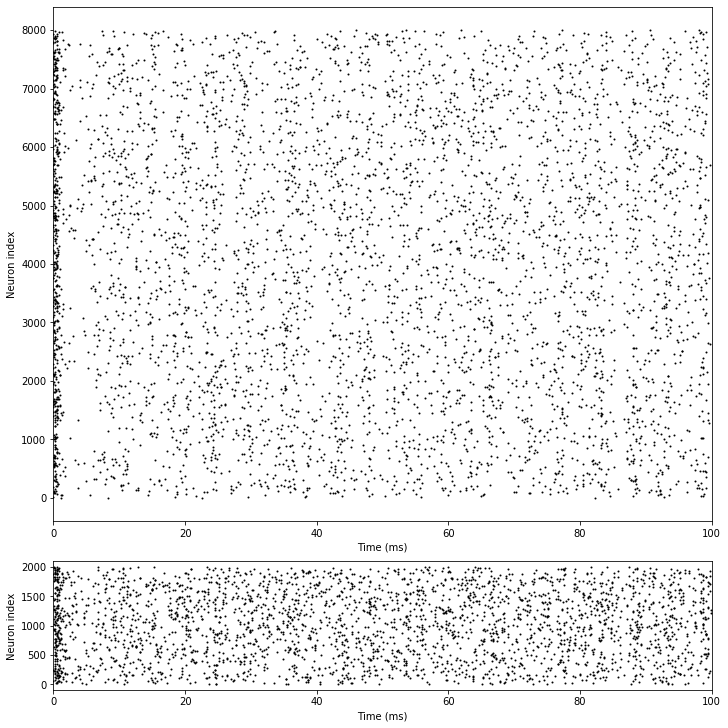

In [6]:
# visualization
fig, gs = bp.visualize.get_figure(5, 1, 2, 10)

bp.visualize.raster_plot(net.ts,
                         E_group.mon.spike,
                         ax=fig.add_subplot(gs[:4, 0]),
                         xlim=(0, 100),
                         show=False)

bp.visualize.raster_plot(net.ts,
                         I_group.mon.spike,
                         ax=fig.add_subplot(gs[4, 0]),
                         xlim=(0, 100),
                         show=True)